In [35]:
# 1. Imports & Global configuration 
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from pathlib import Path
from requests import get
from functools import wraps
from collections import defaultdict

DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

RAW_DIR = DATA_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

CALENDAR_YMD = "20240614"
LISTINGS_YMD = "20250615"
CITY = "London"

HOST = "https://orca.casa.ucl.ac.uk"
ORCA_PATH = "~jreades/data"

# ORCA filenames
CALENDAR_FILE = RAW_DIR / f"{CALENDAR_YMD}-{CITY}-calendar.csv.gz"
LISTINGS_FILE = RAW_DIR / f"{LISTINGS_YMD}-{CITY}-listings.csv.gz"

In [45]:
# 2. cache helper
def check_cache(f):
    @wraps(f)
    def wrapper(src: str, dst_dir: Path, min_size: int = 100) -> Path:
        src0 = src.split("?")[0]
        fn = Path(src0).name
        dst = dst_dir / fn

        if dst.is_file() and dst.stat().st_size > min_size:
            print(f"+ {dst} found locally!")
            return dst
        else:
            print(f"+ {dst} not found, downloading!")
            return f(src, dst)
    return wrapper


@check_cache
def cache_data(src: str, dst: Path) -> Path:
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True, exist_ok=True)

    with dst.open("wb") as f:
        r = get(src)
        r.raise_for_status()
        f.write(r.content)

    print("+ Done downloading.")
    return dst.resolve()

In [37]:
# 3. download/cache ORCA data
listings_url = f"{HOST}/{ORCA_PATH}/{LISTINGS_FILE.name}"
calendar_url = f"{HOST}/{ORCA_PATH}/{CALENDAR_FILE.name}"

listings_path = cache_data(listings_url, RAW_DIR)
calendar_path = cache_data(calendar_url, RAW_DIR)

+ data/raw/20250615-London-listings.csv.gz found locally!
+ data/raw/20240614-London-calendar.csv.gz found locally!


In [ ]:
# 4. read listings
listings = pd.read_csv(listings_path)

print("Listings:", listings.shape)

In [22]:
# 5.read calendar by chunks
CHUNK_SIZE  = 200_000

def summarise_calendar_streaming(
    path: Path,
    chunk_size: int = CHUNK_SIZE,
    start_date: str = "2024-06-14",
    end_date: str   = "2025-06-14",
) -> pd.DataFrame:

    agg = {}  # {listing_id: [occupied_nights, total_nights]}

    for chunk in pd.read_csv(
        path,
        chunksize=chunk_size,
        usecols=["listing_id", "available", "date"],
        low_memory=False
    ):

        chunk["date"] = pd.to_datetime(chunk["date"], errors="coerce")
        chunk = chunk.dropna(subset=["date"])

        mask = (chunk["date"] >= start_date) & (chunk["date"] < end_date)
        chunk = chunk.loc[mask]
        if chunk.empty:
            continue

        chunk["is_occupied"] = (
            chunk["available"].astype(str).str.lower() == "f"
        )

        grouped = (
            chunk
            .groupby("listing_id")["is_occupied"]
            .agg(["sum", "count"])
            .reset_index()
        )

        for _, row in grouped.iterrows():
            lid = int(row["listing_id"])
            occ = int(row["sum"])
            tot = int(row["count"])

            if lid not in agg:
                agg[lid] = [0, 0]

            agg[lid][0] += occ
            agg[lid][1] += tot

    summary = (
        pd.DataFrame.from_dict(
            agg,
            orient="index",
            columns=["occupied_nights", "total_nights"]
        )
        .reset_index()
        .rename(columns={"index": "listing_id"})
    )

    summary["available_nights"] = (
        summary["total_nights"] - summary["occupied_nights"]
    )
    summary["occupancy_rate"] = (
        summary["occupied_nights"] / summary["total_nights"]
    )

    return summary
occ_summary = summarise_calendar_streaming(CALENDAR_FILE)
print(occ_summary.shape)
print(occ_summary.head())

FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/20240614-London-calendar.csv.gz'

In [26]:
# 6. thresholds / constants
VIOLATION_THRESHOLD        = 90
COMMERCIAL_AVAIL_THRESHOLD = 60
HOTEL_LIKE_OCC_THRESHOLD   = 180

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10

In [27]:
# 7. Core wrangling helpers (used by Q1/Q2/Q3)
def load_listings(path: Path) -> pd.DataFrame:
    cols_in_file = pd.read_csv(path, nrows=0).columns.tolist()

    desired_cols = [
        "id", "host_id", "room_type",
        "neighbourhood_cleansed", "neighbourhood_group_cleansed",
        "latitude", "longitude",
        "number_of_reviews", "price",
    ]
    usecols = [c for c in desired_cols if c in cols_in_file]

    df = pd.read_csv(path, usecols=usecols, low_memory=False)

    if "price" in df.columns:
        price_str = df["price"].astype(str).str.replace(r"[^\d.]", "", regex=True)
        df["price_clean"] = pd.to_numeric(price_str, errors="coerce")
    else:
        df["price_clean"] = np.nan

    return df


def merge_calendar_listings(occ_summary: pd.DataFrame, listings: pd.DataFrame) -> pd.DataFrame:
    cols_to_keep = [
        "id", "host_id", "room_type",
        "neighbourhood_cleansed", "neighbourhood_group_cleansed",
        "latitude", "longitude",
        "number_of_reviews", "price_clean",
    ]
    existing_cols = [c for c in cols_to_keep if c in listings.columns]

    merged = occ_summary.merge(
        listings[existing_cols].drop_duplicates(subset="id"),
        left_on="listing_id",
        right_on="id",
        how="left",
    )
    return merged


def add_core_flags(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["is_entire_home"] = df["room_type"].eq("Entire home/apt")

    if not {"occupied_nights", "available_nights"}.issubset(df.columns):
        raise ValueError("缺少 occupied_nights 或 available_nights 列。")

    df["violates_90day"] = df["occupied_nights"] > VIOLATION_THRESHOLD
    df["commercial_STR"] = df["available_nights"] > COMMERCIAL_AVAIL_THRESHOLD
    df["hotel_like"]     = df["occupied_nights"] > HOTEL_LIKE_OCC_THRESHOLD

    df["legal_but_commercial"] = (~df["violates_90day"]) & df["commercial_STR"]
    return df


def prepare_merged(
    calendar_path: Path,
    listings_path: Path,
    start_date: str = "2024-06-14",
    end_date: str   = "2025-06-14",
) -> pd.DataFrame:
    print(f"=== Core Step: Summarising calendar {start_date} ~ {end_date} ===")
    occ_summary = summarise_calendar_streaming(
        calendar_path,
        chunk_size=CHUNK_SIZE,
        start_date=start_date,
        end_date=end_date,
    )
    print("  Listings with calendar data:", len(occ_summary))

    print("=== Core Step: Loading listings and merging ===")
    listings = load_listings(listings_path)
    merged = merge_calendar_listings(occ_summary, listings)
    merged = add_core_flags(merged)

    del occ_summary
    del listings

    print("  Total listings in merged:", merged["listing_id"].nunique())
    print("  Columns:", list(merged.columns))
    return merged


In [28]:
# 8. read calendar&listings，merge, flag
merged = prepare_merged(
    calendar_path=calendar_path,
    listings_path=listings_path
)

NameError: name 'calendar_path' is not defined

In [29]:
# 9. 
print("merged shape:", merged.shape)
print("columns:", list(merged.columns)[:30], "...")

need_cols = ["listing_id", "occupied_nights", "available_nights", "room_type",
             "is_entire_home", "violates_90day", "commercial_STR", BOROUGH_COL]
for c in need_cols:
    print(f"{c}: ", "OK" if c in merged.columns else "MISSING")

if "room_type" in merged.columns:
    print("\nroom_type value counts (top 10):")
    print(merged["room_type"].value_counts(dropna=False).head(10))

if "is_entire_home" in merged.columns:
    print("\nis_entire_home counts:")
    print(merged["is_entire_home"].value_counts(dropna=False))

if BOROUGH_COL in merged.columns:
    print(f"\n{BOROUGH_COL} missing rate:", merged[BOROUGH_COL].isna().mean())
    print(f"{BOROUGH_COL} top 10:")
    print(merged[BOROUGH_COL].value_counts(dropna=False).head(10))


NameError: name 'merged' is not defined

In [62]:
# 10.Policy

# entire-home
def _unique_entire_listings(df: pd.DataFrame) -> pd.DataFrame:
    out = df[df["is_entire_home"]].copy()
    out = out.drop_duplicates(subset="listing_id")
    return out


def citywide_violation_stats(df: pd.DataFrame) -> dict:
    entire = _unique_entire_listings(df)
    total_entire = entire["listing_id"].nunique()

    n_viol = int(entire["violates_90day"].sum())
    share_viol = n_viol / total_entire if total_entire > 0 else np.nan

    n_comm = int(entire["commercial_STR"].sum())
    share_comm = n_comm / total_entire if total_entire > 0 else np.nan

    overlap = int((entire["violates_90day"] & entire["commercial_STR"]).sum())
    overlap_rate = overlap / n_viol if n_viol > 0 else np.nan

    return {
        "total_entire_homes": int(total_entire),
        "n_violates_90day": int(n_viol),
        "share_violates_90day": share_viol,
        "n_commercial_entire": int(n_comm),
        "share_commercial_entire": share_comm,
        "overlap_count": int(overlap),
        "overlap_rate_within_violations": overlap_rate,
    }

def neighbourhood_violation_stats(df: pd.DataFrame) -> pd.DataFrame:
    entire = _unique_entire_listings(df)
    entire = entire.dropna(subset=[BOROUGH_COL]).copy()

    grouped = (
        entire
        .groupby(BOROUGH_COL)
        .agg(
            n_entire=("listing_id", "nunique"),
            n_violations=("violates_90day", "sum"),
            n_commercial=("commercial_STR", "sum"),
        )
        .reset_index()
        .rename(columns={BOROUGH_COL: "borough"})
    )

    grouped["share_violations"] = grouped["n_violations"] / grouped["n_entire"]
    grouped["share_commercial"] = grouped["n_commercial"] / grouped["n_entire"]

    return grouped

# Figure 1 
def plot_occupied_histogram(df: pd.DataFrame) -> None:
    entire = _unique_entire_listings(df)

    plt.figure()
    plt.hist(entire["occupied_nights"].dropna(), bins=30)
    plt.axvline(
        VIOLATION_THRESHOLD,
        color="red",
        linestyle="--",
        label="90-night limit"
    )
    plt.xlabel("Occupied nights (entire homes)")
    plt.ylabel("Number of listings")
    plt.title("Distribution of occupied nights (entire homes)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Figure 2
def plot_top_violation_areas(neigh_stats: pd.DataFrame, top_n: int = 20) -> None:
    df = neigh_stats.sort_values("share_violations", ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(df["borough"], df["share_violations"])
    plt.gca().invert_yaxis()
    plt.xlabel("Share of entire homes violating 90-day rule")
    plt.ylabel("Borough")
    plt.title(f"Top {top_n} boroughs by 90-day rule violation rate")
    plt.tight_layout()
    plt.show()


# Figure 3 
def plot_share_commercial_vs_violations(neigh_stats: pd.DataFrame) -> None:
    df = neigh_stats.dropna(subset=["share_violations", "share_commercial"]).copy()
    if df.empty:
        print("No borough data，skip offset points.")
        return

    plt.figure(figsize=(7, 6))
    plt.scatter(df["share_violations"], df["share_commercial"])

    for _, row in df.iterrows():
        plt.annotate(
            row["borough"],
            (row["share_violations"], row["share_commercial"]),
            fontsize=8,
            xytext=(3, 3),
            textcoords="offset points",
        )

    plt.xlabel("Share of 90-day violations (entire homes)")
    plt.ylabel("Share of commercial STR (entire homes)")
    plt.title("Commercial STR vs 90-day violations by borough")
    plt.tight_layout()
    plt.show()


def run_policy_from_merged(merged: pd.DataFrame) -> dict:
    print("=== Policy: city-level stats ===")
    city_stats = citywide_violation_stats(merged)
    for k, v in city_stats.items():
        if isinstance(v, float):
            if "share" in k or "rate" in k:
                print(f"  {k}: {v:.2%}")
            else:
                print(f"  {k}: {v:.2f}")
        else:
            print(f"  {k}: {v}")

    print("\n=== Policy: borough-level stats ===")
    neigh_stats = neighbourhood_violation_stats(merged)
    print(neigh_stats.head())

    print("\n=== Figure 1 ===")
    plot_occupied_histogram(merged)

    print("\n=== Figure 2 ===")
    plot_top_violation_areas(neigh_stats, top_n=20)

    print("\n=== Figure 3 ===")
    plot_share_commercial_vs_violations(neigh_stats)

    print("\n=== Policy analysis done. ===")
    return {
        "city_stats": city_stats,
        "borough_stats": neigh_stats
    }


In [31]:
# 11 Policy Result 
results_policy = run_policy_from_merged(merged)

NameError: name 'merged' is not defined

In [32]:
# 6. group-provided borough data (local)

TABLE_DIR = DATA_DIR / "table"
TABLE_DIR.mkdir(parents=True, exist_ok=True)

RENT_EXCEL_PATH =TABLE_DIR / "borough_rent_2024_07_2025_06.xlsx"

if not RENT_EXCEL_PATH.exists():
    raise FileNotFoundError(f"Missing file: {RENT_EXCEL_PATH.resolve()}")

rent  = pd.read_excel(RENT_EXCEL_PATH)

print("Rent:", rent.shape)

FileNotFoundError: Missing file: /home/jovyan/work/fsds/fsds-group/data/table/borough_rent_2024_07_2025_06.xlsx

In [56]:
# 12 Commercial
def _unique_listings(df: pd.DataFrame) -> pd.DataFrame:
    if "listing_id" not in df.columns:
        raise ValueError("DataFrame 缺少 listing_id 列。")
    return df.drop_duplicates(subset="listing_id").copy()


def compute_entire_home_stats(df: pd.DataFrame) -> dict:
    d = _unique_listings(df)

    total_listings = d["listing_id"].nunique()
    entire = d[d["is_entire_home"]]
    n_entire = entire["listing_id"].nunique()
    share_entire = n_entire / total_listings if total_listings > 0 else np.nan

    return {
        "total_listings": int(total_listings),
        "n_entire": int(n_entire),
        "share_entire": share_entire,
    }


def compute_host_structure(df: pd.DataFrame) -> dict:
    d = _unique_listings(df)

    d = d.dropna(subset=["host_id"]).copy()

    host_counts = d.groupby("host_id")["listing_id"].nunique()
    total_hosts = int(host_counts.size)
    total_listings = int(d["listing_id"].nunique())

    n_multi_hosts = int((host_counts >= 2).sum())
    listing_by_multi = int(host_counts[host_counts >= 2].sum())

    stats = {
        "host_counts": host_counts,
        "total_hosts": total_hosts,
        "total_listings": total_listings,
        "n_multi_hosts": n_multi_hosts,
        "share_multi_hosts": (n_multi_hosts / total_hosts) if total_hosts > 0 else np.nan,
        "listing_by_multi": listing_by_multi,
        "share_listing_by_multi": (listing_by_multi / total_listings) if total_listings > 0 else np.nan,
    }
    return stats


def compute_availability_stats(df: pd.DataFrame) -> dict:
    """
    Availability-based STR categories (entire homes only):
      - commercial_STR / hotel_like / legal_but_commercial 这些 flag 已经在 merged 里打好
    """
    d = _unique_listings(df)
    entire = d[d["is_entire_home"]].copy()
    n_entire = int(entire["listing_id"].nunique())

    n_commercial = int(entire["commercial_STR"].sum())
    share_commercial = n_commercial / n_entire if n_entire > 0 else np.nan

    n_hotel_like = int(entire["hotel_like"].sum())
    share_hotel_like = n_hotel_like / n_entire if n_entire > 0 else np.nan

    n_legal_but_commercial = int(entire["legal_but_commercial"].sum())
    share_legal_but_comm = n_legal_but_commercial / n_entire if n_entire > 0 else np.nan

    return {
        "n_entire": n_entire,
        "n_commercial_entire": n_commercial,
        "share_commercial_entire": share_commercial,
        "n_hotel_like_entire": n_hotel_like,
        "share_hotel_like_entire": share_hotel_like,
        "n_legal_but_commercial_entire": n_legal_but_commercial,
        "share_legal_but_commercial_entire": share_legal_but_comm,
    }


#Figure 4.
def plot_host_distribution(host_structure_stats: dict, max_listings: int = 12) -> None:
    host_counts: pd.Series = host_structure_stats["host_counts"]
    vc = host_counts.value_counts().sort_index()

    vc_main = vc[vc.index <= max_listings].copy()
    others = int(vc[vc.index > max_listings].sum())

    if others > 0:
        vc_main.loc[max_listings + 1] = others
        labels = [str(i) for i in range(1, max_listings + 1)] + [f"{max_listings+1}+"]
        vc_main.index = labels
    else:
        vc_main.index = [str(i) for i in vc_main.index]

    plt.figure()
    vc_main.plot(kind="bar")
    plt.xlabel("Number of listings per host")
    plt.ylabel("Number of hosts")
    plt.title("Host size distribution (market structure)")
    plt.tight_layout()
    plt.show()


# Figure 5.
def plot_commercial_shares(avail_stats: dict) -> None:
    labels = [
        "Commercial STR (entire)",
        "Hotel-like STR (entire)",
        "Legal but commercial (entire)",
    ]
    values = [
        avail_stats["share_commercial_entire"],
        avail_stats["share_hotel_like_entire"],
        avail_stats["share_legal_but_commercial_entire"],
    ]

    plt.figure()
    plt.bar(labels, values)
    plt.ylabel("Share of entire homes")
    plt.title("Availability-based STR categories")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()


def run_commercial_from_merged(merged: pd.DataFrame) -> dict:
    """
    Commercial analysis (restricted):
      - Entire-home share (printed)
      - Host structure (printed)
      - Availability-based categories (printed)
      - Figures:
          C1 Host size distribution
          C2 Availability-based STR categories
    """
    print("=== Commercial: Entire-home share ===")
    entire_stats = compute_entire_home_stats(merged)
    print(entire_stats)

    print("\n=== Commercial: Host structure ===")
    host_stats = compute_host_structure(merged)
    print("Total hosts:", host_stats["total_hosts"])
    print("Multi-host share:", host_stats["share_multi_hosts"])
    print("Listings controlled by multi-hosts:", host_stats["share_listing_by_multi"])

    print("\n=== Commercial: Availability-based STR categories ===")
    avail_stats = compute_availability_stats(merged)
    for k, v in avail_stats.items():
        if k.startswith("share_"):
            print(f"{k}: {v:.2%}")
        else:
            print(f"{k}: {v}")

    print("\n=== Figure C1: Host size distribution ===")
    plot_host_distribution(host_stats, max_listings=12)

    print("\n=== Figure C2: Availability-based STR categories ===")
    plot_commercial_shares(avail_stats)

    print("\n=== Commercial analysis done . ===")
    return {
        "entire_stats": entire_stats,
        "host_stats": host_stats,
        "avail_stats": avail_stats,
    }

=== Commercial: Entire-home share ===
{'total_listings': 93480, 'n_entire': 40112, 'share_entire': 0.4290971330765939}

=== Commercial: Host structure ===
Total hosts: 43329
Multi-host share: 0.16704747397816705
Listings controlled by multi-hosts: 0.44942106146359323

=== Commercial: Availability-based STR categories ===
n_entire: 40112
n_commercial_entire: 20330
share_commercial_entire: 50.68%
n_hotel_like_entire: 27798
share_hotel_like_entire: 69.30%
n_legal_but_commercial_entire: 6737
share_legal_but_commercial_entire: 16.80%

=== Figure C1: Host size distribution ===


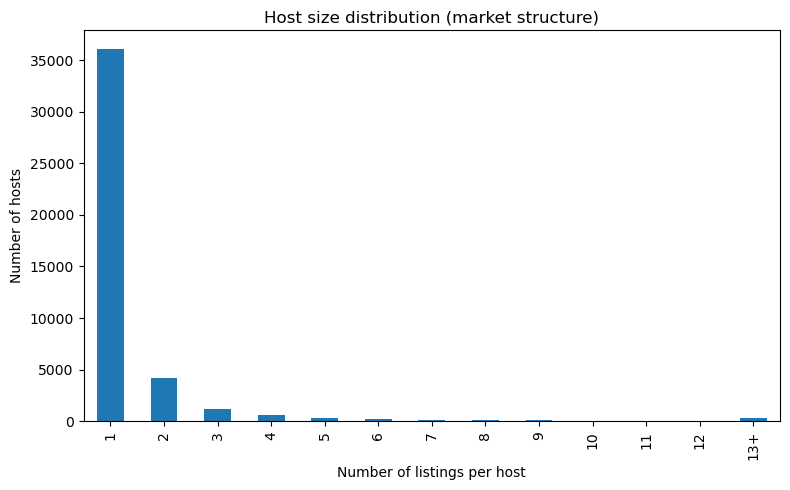


=== Figure C2: Availability-based STR categories ===


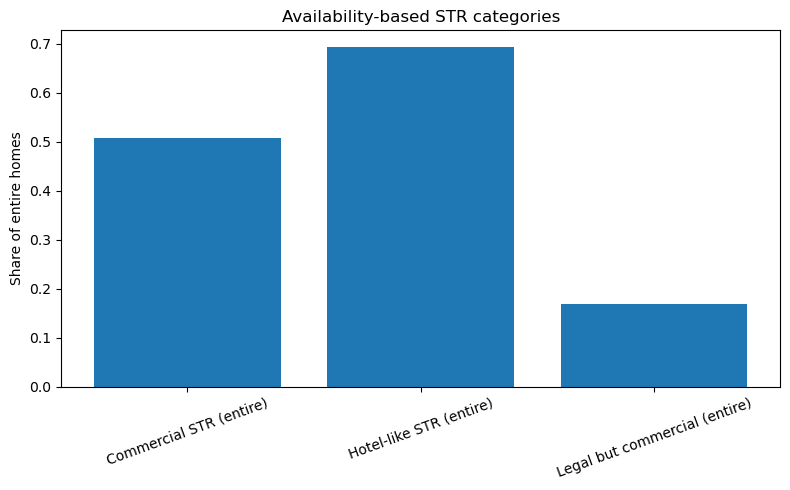


=== Commercial analysis done . ===


In [57]:
# 13 Commercial Result 
results_commercial = run_commercial_from_merged(merged)

In [58]:
# 14 Spatial Read 
GEO_DIR = DATA_DIR / "geo"
GEO_DIR.mkdir(parents=True, exist_ok=True)

url = "https://raw.githubusercontent.com/jreades/fsds/master/data/src/Boroughs.gpkg"
out = GEO_DIR / "Boroughs.gpkg"

if not out.exists() or out.stat().st_size < 1000:
    print("Downloading Boroughs.gpkg ...")
    r = requests.get(url)
    r.raise_for_status()
    out.write_bytes(r.content)
else:
    print("Boroughs.gpkg already exists")

out

Boroughs.gpkg already exists


PosixPath('data/geo/Boroughs.gpkg')

In [88]:
# 15 import geopandas as gpd
import pandas as pd

boros = gpd.read_file("data/geo/Boroughs.gpkg")
boros["borough"] = boros["NAME"].astype(str).str.strip().str.lower()

pts = gpd.GeoDataFrame(
    merged.copy(),
    geometry=gpd.points_from_xy(merged["longitude"], merged["latitude"]),
    crs="EPSG:4326"
)

pts = pts.to_crs(boros.crs)

pts_boro = gpd.sjoin(
    pts,
    boros[["borough", "geometry"]],
    how="left",
    predicate="within"  
)

pts_boro["borough"].isna().mean()
pts_boro[["listing_id","borough"]].head()


,listing_id,borough
0,13913,islington
1,15400,kensington and chelsea
2,17402,westminster
3,24328,wandsworth
4,33332,NaN


In [87]:
#16 Stock Read
STOCK_CSV_PATH =TABLE_DIR /"social-landlord-housing-stock-borough.csv"

if not STOCK_CSV_PATH.exists():
    raise FileNotFoundError(f"Missing file:{STOCK_CSV_PATH.resolve()}")

stock = pd.read_csv(STOCK_CSV_PATH)

print("Stock:", stock.shape)
stock.head()
stock.columns
stock.dtypes

FileNotFoundError: Missing file:/home/jovyan/work/fsds/fsds-group/data/table/social-landlord-housing-stock-borough.csv

In [77]:
#17 Stock 
stock2 = stock.copy()
stock2["borough"] = stock2["Area"].astype(str).str.strip().str.lower()

dwell_col = "Number of self-contained units or bedspaces-2024"
print("Using dwellings column:", dwell_col)

housing = stock2[["borough", dwell_col]].rename(
    columns={dwell_col: "dwellings"}
).copy()

housing["dwellings"] = (
    housing["dwellings"]
    .astype(str)
    .str.replace(",", "", regex=False)
)

housing["dwellings"] = pd.to_numeric(
    housing["dwellings"],
    errors="coerce"
)

housing.head()

NameError: name 'stock' is not defined

In [78]:
#18 Select professional landlords
cols = [
    "id", "host_id", "room_type",
    "availability_365", "neighbourhood_cleansed",
    "latitude", "longitude"
]

df = listings[cols].copy()    
print("Columns loaded:", df.columns)

Columns loaded: Index(['id', 'host_id', 'room_type', 'availability_365',
       'neighbourhood_cleansed', 'latitude', 'longitude'],
      dtype='object')


In [102]:
#19 calculate professional landlords
host_stats = df.groupby("host_id").agg(
    total_listings = ('id','count'),
    entire_homes   = ('room_type', lambda x: (x=="Entire home/apt").sum()),
    avail_over_90  = ('availability_365', lambda x: (x>90).sum())
).reset_index()

host_stats["is_PL"] = (
    ((host_stats.total_listings >= 3) | (host_stats.entire_homes >= 2))
    & (host_stats.avail_over_90 > 0)
)

final_hosts = host_stats[host_stats.is_PL].host_id.unique()

Q2 = len(final_hosts)
print("Q2 Number of professional landlords =", Q2)

Q2 Number of professional landlords = 5345


In [103]:
#19 Calculate host's listing and proportion
df["is_PL_listing"] = df["host_id"].isin(final_hosts)
Q31 = df["is_PL_listing"].sum()
print("Q3.1 Number of Properties Owned by Professional Landlords =", Q31)

total_listings = len(df)
Q32 = Q31 / total_listings
print("Q3.2 Proportion of properties listed by professional landlords =", round(Q32,4))

Q3.1 Number of Properties Owned by Professional Landlords = 37609
Q3.2 Proportion of properties listed by professional landlords = 0.3891


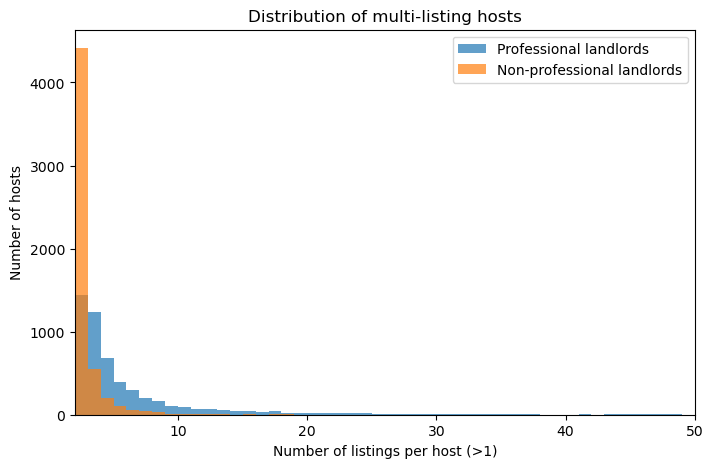

In [107]:
#20 Map distribution of multi-listing hosts
PL_hosts = host_stats[host_stats.is_PL]
non_PL_hosts = host_stats[~host_stats.is_PL]

PL_plot = PL_hosts[PL_hosts.total_listings > 1]
non_PL_plot = non_PL_hosts[non_PL_hosts.total_listings > 1]

plt.figure(figsize=(8,5))

plt.hist(
    PL_plot["total_listings"],
    bins=range(2, 50),
    alpha=0.7,
    label="Professional landlords"
)

plt.hist(
    non_PL_plot["total_listings"],
    bins=range(2, 50),
    alpha=0.7,
    label="Non-professional landlords"
)

plt.xlim(2, 50)
plt.xlabel("Number of listings per host (>1)")
plt.ylabel("Number of hosts")
plt.title("Distribution of multi-listing hosts")
plt.legend()
plt.show()

In [115]:
#21 Generate point data + spatial join
if "is_PL" not in merged.columns:
    merged = merged.merge(
        host_stats[["host_id", "is_PL"]],
        on="host_id",
        how="left"
    )
    merged["is_PL"] = merged["is_PL"].fillna(False)

pts = gpd.GeoDataFrame(
    merged.copy(),
    geometry=gpd.points_from_xy(merged["longitude"], merged["latitude"]),
    crs="EPSG:4326"
).to_crs(boros.crs)

pts_boro = gpd.sjoin(
    pts,
    boros[["borough", "geometry"]],
    how="left",
    predicate="within"
)

pl_pts = pts_boro[pts_boro["is_PL"] == True].copy()

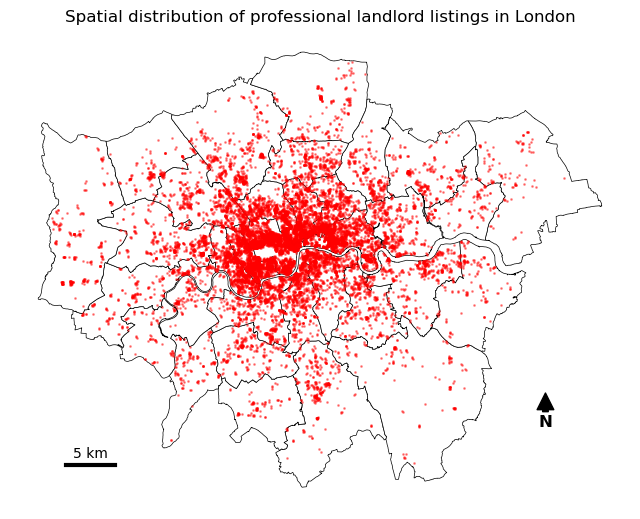

In [120]:
#22 Plot professional landlord listings on the map

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Borough boundaries
boros.plot(
    ax=ax,
    color="white",
    edgecolor="black",
    linewidth=0.5
)

# Professional landlord listings
pl_pts.plot(
    ax=ax,
    color="red",
    markersize=1,
    alpha=0.4
)

ax.set_title("Spatial distribution of professional landlord listings in London")
ax.axis("off")

# ---- Scale bar ----
xmin, ymin, xmax, ymax = boros.total_bounds
scale_length = 5000  # 5 km

x_start = xmin + 0.05 * (xmax - xmin)
y_start = ymin + 0.05 * (ymax - ymin)

ax.plot(
    [x_start, x_start + scale_length],
    [y_start, y_start],
    color="black",
    linewidth=3
)

ax.text(
    x_start + scale_length / 2,
    y_start + 0.01 * (ymax - ymin),
    "5 km",
    ha="center",
    va="bottom",
    fontsize=10
)

# ---- North arrow ----
arrow_x = xmin + 0.90 * (xmax - xmin)
arrow_y = ymin + 0.15 * (ymax - ymin)

ax.annotate(
    'N',
    xy=(arrow_x, arrow_y + 3000),
    xytext=(arrow_x, arrow_y),
    arrowprops=dict(facecolor='black', width=4, headwidth=12),
    ha='center',
    va='center',
    fontsize=12,
    fontweight='bold'
)

plt.show()
